In [1]:
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.models import save_model
from tensorflow.python.keras.metrics import AUC
from deepctr.feature_column import DenseFeat, get_feature_names
from deepctr.models.multitask.composite_optimizer import CompositeOptimizer
from deepctr.models.transferlearning.domain_adaptation import DomainAdaptation
from deepctr.models.transferlearning.transferloss import DomainAdversarialLoss, MMDLoss
from deepctr.models.transferlearning.basenet import SimpleDNN
from deepctr.call_backs import MyEarlyStopping, ModifiedExponentialDecay
from deepctr.models.transferlearning.utils import plot_tsne_source_target, proxy_a_distance

In [2]:
dz_ts = pd.read_csv('D:\\PycharmProjects\\DeepCTR\\examples\\data\\data_K3_dz_samples.csv')
dq_ts = pd.read_csv('D:\\PycharmProjects\\DeepCTR\\examples\\data\\data_dq_0716_updated.csv')

dz_ts['fpd4_weight'] = 1.0
dz_ts['fpd4_mask'] = 1.0
dz_ts.loc[(dz_ts['if_fpd_t4'] != 1), 'fpd4_weight'] = 0.0
dz_ts.loc[(dz_ts['if_fpd_t4'] != 1), 'fpd4_mask'] = 0

dq_ts['fpd4_weight'] = 1.0
dq_ts['fpd4_mask'] = 1.0
dq_ts.loc[(dq_ts['if_fpd_t4'] != 1), 'fpd4_weight'] = 0.0
dq_ts.loc[(dq_ts['if_fpd_t4'] != 1), 'fpd4_mask'] = 0

dz_all = dz_ts[(dz_ts.shouxin_date>='2019-09-01') & (dz_ts.shouxin_date<'2020-05-01')][
        ['cust_no','shouxin_date','fpd4', 'fpd4_weight', 'fpd4_mask'] +
        ['ali_rain_score','bj_jc_m36_consume_cnt','td_zhixin_score','hds_36m_purchase_steady','hds_36m_total_purchase_cnt','hds_36m_month_max_purchase_money_excp_doub11_12','hds_36m_doub11_12_total_purchase_money','hds_phone_rich_rank','hds_mobile_rich','hds_mobile_reli_rank','hds_recent_consumme_active_rank'] +
        ['ab_local_ratio','ab_mobile_cnt','app_type','cust_gender','cust_id_area','cust_work_city','idcard_district_grade','idcard_rural_flag','immediate_relation_cnt','operation_sys','relation_contact_cnt','study_app_cnt','selffill_degree','selffill_is_have_creditcard','selffill_marital_status','ab_local_cnt','ab_prov_cnt']]

dz_all['hds_mobile_reli_rank_Ma'] = dz_all.hds_mobile_reli_rank.apply(lambda x : 1 if x=='Ma' else 0)
dz_all['hds_mobile_reli_rank_Mb'] = dz_all.hds_mobile_reli_rank.apply(lambda x : 1 if x=='Mb' else 0)
dz_all['hds_mobile_reli_rank_M0'] = dz_all.hds_mobile_reli_rank.apply(lambda x : 1 if x=='M0' else 0)
dz_all['hds_recent_consumme_active_rank'] = dz_all.hds_recent_consumme_active_rank.apply(lambda x : float(str(x).replace('}','')))
dz_all['is_ios'] = dz_all['operation_sys'].apply(lambda x : 1 if x in ['ios','IOS','iPhone OS'] else(0 if x in ['android','Android'] else -99))
dz_all['is_male'] = dz_all['cust_gender'].apply(lambda x : 1 if x=='M' else(0 if x=='F' else -99))
dz_all['selffill_is_have_creditcard'] = dz_all['selffill_is_have_creditcard'].apply(lambda x : 1 if x == 'Y' else(0 if x == 'N' else -99))
dz_all['credit_repayment_score_bj_2'] = -99
dz_all['td_xyf_dq_score'] = -99
dz_all.fillna(-99, inplace=True)
dz_all = dz_all.replace([-99], -1)

source = dz_all

candidate_features = ['cust_no','shouxin_date','fpd4', 'fpd4_weight', 'fpd4_mask'] +\
        ['ali_rain_score','bj_jc_m36_consume_cnt','credit_repayment_score_bj_2',
         'td_xyf_dq_score','td_zhixin_score','hds_36m_purchase_steady','hds_36m_total_purchase_cnt',
         'hds_36m_month_max_purchase_money_excp_doub11_12','hds_36m_doub11_12_total_purchase_money',
         'hds_phone_rich_rank','hds_mobile_rich','hds_mobile_reli_rank','hds_recent_consumme_active_rank'] +\
        ['ab_local_ratio','ab_mobile_cnt','app_type','cust_gender','cust_id_area','cust_work_city',
         'idcard_district_grade','idcard_rural_flag','immediate_relation_cnt','operation_sys','relation_contact_cnt',
         'study_app_cnt','selffill_degree','selffill_is_have_creditcard','selffill_marital_status','ab_local_cnt','ab_prov_cnt']

dq_all = dq_ts[(dq_ts.shouxin_date >= '2019-07-23')][candidate_features]

dq_all['hds_mobile_reli_rank_Ma'] = dq_all.hds_mobile_reli_rank.apply(lambda x : 1 if x=='Ma' else 0)
dq_all['hds_mobile_reli_rank_Mb'] = dq_all.hds_mobile_reli_rank.apply(lambda x : 1 if x=='Mb' else 0)
dq_all['hds_mobile_reli_rank_M0'] = dq_all.hds_mobile_reli_rank.apply(lambda x : 1 if x=='M0' else 0)
dq_all['hds_recent_consumme_active_rank'] = dq_all.hds_recent_consumme_active_rank.apply(lambda x : float(str(x).replace('}','')))
dq_all['is_ios'] = dq_all['operation_sys'].apply(lambda x : 1 if x in ['ios','IOS','iPhone OS'] else(0 if x in ['android','Android'] else -99))
dq_all['is_male'] = dq_all['cust_gender'].apply(lambda x : 1 if x=='M' else(0 if x=='F' else -99))
dq_all['selffill_is_have_creditcard'] = dq_all['selffill_is_have_creditcard'].apply(lambda x : 1 if x == 'Y' else(0 if x == 'N' else -99))
dq_all['td_xyf_dq_score'] = dq_all['td_xyf_dq_score'].apply(lambda x : -99 if x==-99 else (x*1000))
dq_all.fillna(-99, inplace=True)
dq_all = dq_all.replace([-99], -1)

target = dq_all

D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (165,186,336,343,406,495) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (25,32,257,264,294,310,341,350,353,377,398,402,403,412,431,439,468,487,511,524,528,531,532,539,542,544,564,565,577,584,585,906,984,1006,1009,1010,1014,1015,1018,1020,1021,1023,1026,1074,1097,1408,1409,1412) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loss_fns = {'fpd4': tf.keras.losses.binary_crossentropy}
metrics_logger = {'fpd4': AUC(name='fpd4_AUC')}
tasks = {'fpd4': 'binary'}
batch_size = 256
epochs = 100

col_x = ['ali_rain_score','bj_jc_m36_consume_cnt','td_zhixin_score','hds_36m_purchase_steady','hds_36m_total_purchase_cnt',
         'hds_36m_month_max_purchase_money_excp_doub11_12','hds_36m_doub11_12_total_purchase_money','hds_phone_rich_rank',
         'hds_mobile_rich','hds_recent_consumme_active_rank','ab_local_ratio','ab_mobile_cnt','cust_id_area',
         'cust_work_city','idcard_district_grade','idcard_rural_flag','immediate_relation_cnt','relation_contact_cnt',
         'study_app_cnt','selffill_degree','selffill_is_have_creditcard','selffill_marital_status','ab_local_cnt',
         'ab_prov_cnt','hds_mobile_reli_rank_Ma','hds_mobile_reli_rank_Mb','hds_mobile_reli_rank_M0','is_ios','is_male',
         'credit_repayment_score_bj_2','td_xyf_dq_score']

sparse_features = []

dense_features = []
for col in col_x:
    if col not in sparse_features:
        dense_features.append(col)

mms = MinMaxScaler(feature_range=(0, 1))
source[dense_features] = mms.fit_transform(source[dense_features])
mms = MinMaxScaler(feature_range=(0, 1))
mms.fit(target[target.shouxin_date < '2020-05-01'][dense_features])
target[dense_features] = mms.transform(target[dense_features])

fixlen_feature_columns = [DenseFeat(feat, 1, ) for feat in dense_features]
dnn_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(dnn_feature_columns)

def concat_all(source, target):
    source_x, source_y, source_weight = source
    target_x, target_y, target_weight = target
    combined_x = {name: tf.concat([source_x[name], target_x[name]], 0) for name in source_x.keys()}
    combined_y = {name: tf.concat([source_y[name], target_y[name]], 0) for name in source_y.keys()}
    combined_weight = {name: tf.concat([source_weight[name], target_weight[name]], 0) for name in source_weight.keys()}
    return (source, target, (combined_x, combined_y, combined_weight))

source.loc[:, 'set'] = '1train'
target.loc[(target.shouxin_date < '2020-05-01'), 'set'] = '2test'
target.loc[(target.shouxin_date >= '2020-05-01') & (target.shouxin_date < '2020-06-01'), 'set'] = '3oot'
target.loc[(target.shouxin_date >= '2020-06-01') & (target.shouxin_date < '2020-07-01'), 'set'] = '4oot'
target.loc[(target.shouxin_date >= '2020-07-01') & (target.shouxin_date <= '2020-08-01'), 'set'] = '5oot'
data = pd.concat([source, target], axis=0).reset_index()

source_x = {name: source[name] for name in feature_names}
source_weight = {task_name: source[task_name+'_weight'] for task_name in tasks.keys()}
source_y = {task_name: source[[task_name]] for task_name in tasks.keys()}

target_x = {name: target[target.shouxin_date < '2020-05-01'][name] for name in feature_names}
target_weight = {task_name: target[target.shouxin_date < '2020-05-01'][task_name+'_weight'] for task_name in tasks.keys()}
target_y = {task_name: target[target.shouxin_date < '2020-05-01'][[task_name]] for task_name in tasks.keys()}

source_batch_num = math.ceil(len(source) / batch_size)
target_batch_num = math.ceil(len(target[target.shouxin_date < '2020-05-01']) / batch_size)
train_iter_num = max(source_batch_num, target_batch_num)
train_iter_num = max(source_batch_num, target_batch_num)
max_iter_num = epochs * train_iter_num

source_dataset = tf.data.Dataset.from_tensor_slices((source_x, source_y, source_weight))
target_dataset = tf.data.Dataset.from_tensor_slices((target_x, target_y, target_weight))
source_dataset = source_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True, seed=0).repeat().batch(batch_size)
target_dataset = target_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True, seed=0).repeat().batch(batch_size)

train_dataset = tf.data.Dataset.zip((source_dataset.take(train_iter_num), target_dataset.take(train_iter_num)))
train_dataset = train_dataset.map(lambda x1, y1: concat_all(x1, y1))


val_dataset = tf.data.Dataset.zip(
    (source_dataset,
     tf.data.Dataset.from_tensor_slices(
         ({name: target[target['set'] == '3oot'][name] for name in feature_names},
          {task_name: target[target['set'] == '3oot'][[task_name]] for task_name in tasks.keys()},
          {task_name: target[target['set'] == '3oot'][task_name + '_weight'] for task_name in tasks.keys()})
     ).batch(batch_size)
    )
)

# a distantance
source_data = data[data['set'] == '1train']
print('source shape ', source_data.shape)
_, source_data = train_test_split(source_data, test_size=min(2000, source_data.shape[0]-1),
                                  random_state=42, shuffle=source_data['fpd4'])
set_name = '2test'
set_data = data[data['set'] == set_name]
print(set_name, 'shape ', set_data.shape)
_, set_data = train_test_split(set_data, test_size=min(2000, set_data.shape[0]-1),
                               random_state=42, shuffle=set_data['fpd4'])

source shape  (17764, 42)
2test shape  (8890, 42)


In [4]:
output_dim = 1
model = SimpleDNN(dnn_feature_columns,
                  tasks,
                  num_outdim=output_dim,
                  dnn_hidden_units=(96, 96),
                  dnn_use_bn=False,
                  l2_reg_embedding=1e-5, l2_reg_dnn=0, dnn_dropout=0, dnn_activation='relu', seed=1024)
model.layers

In [5]:
last_lr = 0.001
optimizer1 = tf.keras.optimizers.Adam(learning_rate=ModifiedExponentialDecay(last_lr, max_iter_num=max_iter_num))
optimizer2 = tf.keras.optimizers.Adam(learning_rate=ModifiedExponentialDecay(last_lr, max_iter_num=max_iter_num))
var1 = []
for layer in model.layers[:-2]:
    var1 += layer.trainable_variables
var2 = []
for layer in model.layers[-2:]:
    var2 += layer.trainable_variables
composite_optimizer = CompositeOptimizer([
    (optimizer1, lambda: var1),
    (optimizer2, lambda: var2)])
model.compile(optimizer=composite_optimizer,
              loss=loss_fns,
              metrics=metrics_logger,
              loss_weights=None,
              uncertainly=None,
              gradnorm_config=None)
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer('bottom_shared_dnn').output)
dann = DomainAdaptation(feature_extractor, model)

In [6]:
da_loss = DomainAdversarialLoss(max_iter_grl=max_iter_num, dnn_units=[24, 8])
dann.compile(da_loss=da_loss,
             optimizer_da_loss=tf.keras.optimizers.Adam(
                 learning_rate=ModifiedExponentialDecay(0.001, max_iter_num=max_iter_num)))
dann.fit(train_dataset,
         validation_data=val_dataset,
         epochs=epochs,
         callbacks=[
             MyEarlyStopping('val_domain_classifier_accuracy',
                             patience=10,
                             savepath='temp',
                             coef_of_balance=0,
                             direction='minimize',
                             persistence=False)
         ]
         )

Epoch 1/100
70/70 [==============================] - 2s 29ms/step - total_loss: 0.2157 - fpd4_AUC: 0.5489 - fpd4_loss: 0.2157 - domain_classifier_accuracy: 0.8354 - da_loss: 0.6010 - val_total_loss: 0.1985 - val_fpd4_AUC: 0.5851 - val_fpd4_loss: 0.1985 - val_domain_classifier_accuracy: 0.5966 - val_da_loss: 0.6778

In [7]:
# epochs * num_batches
dann.optimizer.iterations

<tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1190>

In [8]:
# epochs * num_batches
dann.optimizer_da_loss.iterations

<tf.Variable 'Adam_2/iter:0' shape=() dtype=int64, numpy=1190>

In [9]:
# the dann model is automatically reset to that of the best epoch
dann.evaluate(val_dataset)

5/5 [==============================] - 0s 12ms/step - total_loss: 0.1990 - fpd4_AUC: 0.5908 - fpd4_loss: 0.1990 - domain_classifier_accuracy: 0.0170 - da_loss: 0.7987


[0.19899031519889832,
 0.5908206105232239,
 0.19899031519889832,
 0.01695583574473858,
 0.7987040281295776]

In [10]:
dann.trainable_variables

[<tf.Variable 'bottom_shared_dnn/kernel0:0' shape=(31, 96) dtype=float32, numpy=
 array([[-0.14046559, -0.04969229,  0.25430918, ..., -0.02618342,
         -0.2130927 , -0.19120607],
        [ 0.02141868,  0.10735191, -0.05534116, ...,  0.06963505,
          0.05709086,  0.00900585],
        [ 0.06430223,  0.03752526,  0.21069725, ...,  0.10034325,
          0.12638433, -0.15745825],
        ...,
        [ 0.07962087,  0.05163278, -0.20988375, ...,  0.01765779,
         -0.07683486, -0.00842067],
        [ 0.11405745,  0.08151353,  0.06452917, ...,  0.05405607,
         -0.00436909,  0.00876404],
        [ 0.14146435, -0.02600158,  0.24670064, ..., -0.24548241,
         -0.17567997,  0.06675463]], dtype=float32)>,
 <tf.Variable 'bottom_shared_dnn/kernel1:0' shape=(96, 96) dtype=float32, numpy=
 array([[ 0.15836617,  0.09584421, -0.12966615, ...,  0.1136502 ,
         -0.16067424, -0.06457647],
        [-0.01250067, -0.09674615,  0.03705568, ...,  0.0048479 ,
         -0.20457436, -0.04

In [11]:
# the same with that part of main_model dann
feature_extractor.trainable_variables

[<tf.Variable 'bottom_shared_dnn/kernel0:0' shape=(31, 96) dtype=float32, numpy=
 array([[-0.14046559, -0.04969229,  0.25430918, ..., -0.02618342,
         -0.2130927 , -0.19120607],
        [ 0.02141868,  0.10735191, -0.05534116, ...,  0.06963505,
          0.05709086,  0.00900585],
        [ 0.06430223,  0.03752526,  0.21069725, ...,  0.10034325,
          0.12638433, -0.15745825],
        ...,
        [ 0.07962087,  0.05163278, -0.20988375, ...,  0.01765779,
         -0.07683486, -0.00842067],
        [ 0.11405745,  0.08151353,  0.06452917, ...,  0.05405607,
         -0.00436909,  0.00876404],
        [ 0.14146435, -0.02600158,  0.24670064, ..., -0.24548241,
         -0.17567997,  0.06675463]], dtype=float32)>,
 <tf.Variable 'bottom_shared_dnn/kernel1:0' shape=(96, 96) dtype=float32, numpy=
 array([[ 0.15836617,  0.09584421, -0.12966615, ...,  0.1136502 ,
         -0.16067424, -0.06457647],
        [-0.01250067, -0.09674615,  0.03705568, ...,  0.0048479 ,
         -0.20457436, -0.04

2test a_score 2.0


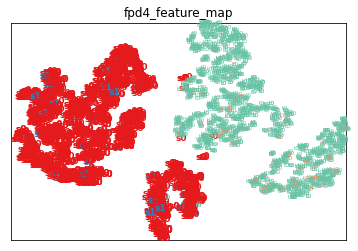

In [23]:
source_x = feature_extractor.predict({name: source_data[name] for name in feature_names})
target_x = feature_extractor.predict({name: set_data[name] for name in feature_names})
a_score = proxy_a_distance(source_x, target_x)
print(set_name, 'a_score', a_score)
fig, ax = plt.subplots()
_ = plot_tsne_source_target(source_x, source_data['fpd4'].values, target_x, set_data['fpd4'].values, ax,
                            name='{}_feature_map'.format('fpd4'))

In [12]:
da_loss = MMDLoss()
dann.compile(da_loss=da_loss,
             optimizer_da_loss=tf.keras.optimizers.Adam(
                 learning_rate=ModifiedExponentialDecay(0.001, max_iter_num=max_iter_num)))

In [13]:
# kept
dann.optimizer.iterations

<tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1190>

In [14]:
# reset
dann.optimizer_da_loss.iterations

<tf.Variable 'iter:0' shape=() dtype=int64, numpy=0>

In [15]:
# the adversarial-loss part is lost, but the feature extractor part is kept
dann.trainable_variables

[<tf.Variable 'bottom_shared_dnn/kernel0:0' shape=(31, 96) dtype=float32, numpy=
 array([[-0.14046559, -0.04969229,  0.25430918, ..., -0.02618342,
         -0.2130927 , -0.19120607],
        [ 0.02141868,  0.10735191, -0.05534116, ...,  0.06963505,
          0.05709086,  0.00900585],
        [ 0.06430223,  0.03752526,  0.21069725, ...,  0.10034325,
          0.12638433, -0.15745825],
        ...,
        [ 0.07962087,  0.05163278, -0.20988375, ...,  0.01765779,
         -0.07683486, -0.00842067],
        [ 0.11405745,  0.08151353,  0.06452917, ...,  0.05405607,
         -0.00436909,  0.00876404],
        [ 0.14146435, -0.02600158,  0.24670064, ..., -0.24548241,
         -0.17567997,  0.06675463]], dtype=float32)>,
 <tf.Variable 'bottom_shared_dnn/kernel1:0' shape=(96, 96) dtype=float32, numpy=
 array([[ 0.15836617,  0.09584421, -0.12966615, ...,  0.1136502 ,
         -0.16067424, -0.06457647],
        [-0.01250067, -0.09674615,  0.03705568, ...,  0.0048479 ,
         -0.20457436, -0.04

In [16]:
dann.fit(train_dataset,
         validation_data=val_dataset,
         epochs=epochs,
         callbacks=[
             MyEarlyStopping('val_fpd4_AUC',
                             patience=10,
                             savepath='temp',
                             coef_of_balance=0,
                             direction='maximize',
                             persistence=False)
         ]
         )

Epoch 1/100
70/70 [==============================] - 5s 65ms/step - total_loss: 0.1729 - fpd4_AUC: 0.6210 - fpd4_loss: 0.1729 - mmd_distance: 0.2483 - val_total_loss: 0.1999 - val_fpd4_AUC: 0.6001 - val_fpd4_loss: 0.1999 - val_mmd_distance: 0.0421

In [17]:
# epochs * num_batches + iterations_of_last_run
dann.optimizer.iterations

<tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=2100>

In [18]:
# the mmd loss does not have any trainable weights, so 0 iters for the optimizer
dann.optimizer_da_loss.iterations

<tf.Variable 'iter:0' shape=() dtype=int64, numpy=0>

In [19]:
# the dann model is automatically reset to that of the best epoch
dann.evaluate(val_dataset)

5/5 [==============================] - 0s 24ms/step - total_loss: 0.1992 - fpd4_AUC: 0.6055 - fpd4_loss: 0.1992 - mmd_distance: 0.0335


[0.1991855949163437,
 0.6054530143737793,
 0.1991855949163437,
 0.033460140228271484]

In [20]:
dann.trainable_variables

[<tf.Variable 'bottom_shared_dnn/kernel0:0' shape=(31, 96) dtype=float32, numpy=
 array([[-0.1814503 , -0.04445853,  0.25365916, ..., -0.02884322,
         -0.25889248, -0.18337736],
        [ 0.0743752 ,  0.09893888,  0.00728303, ...,  0.0661046 ,
          0.05716342,  0.01268009],
        [ 0.05268449,  0.04142283,  0.2429642 , ...,  0.1202907 ,
          0.13199885, -0.14314456],
        ...,
        [ 0.13008086,  0.04329101, -0.15244249, ...,  0.00994699,
         -0.08330194, -0.00720736],
        [ 0.05360007,  0.09049317,  0.00536939, ...,  0.06231819,
         -0.00595377,  0.01389045],
        [ 0.08926344, -0.01714184,  0.19133638, ..., -0.2381346 ,
         -0.17206934,  0.06979264]], dtype=float32)>,
 <tf.Variable 'bottom_shared_dnn/kernel1:0' shape=(96, 96) dtype=float32, numpy=
 array([[ 0.12544346,  0.09584421, -0.12886213, ...,  0.11336764,
         -0.16067424, -0.06457647],
        [-0.04647758, -0.09674615,  0.03705568, ..., -0.00633299,
         -0.20457436, -0.04

In [21]:
# the same with that part of the main model-dann
feature_extractor.trainable_variables

[<tf.Variable 'bottom_shared_dnn/kernel0:0' shape=(31, 96) dtype=float32, numpy=
 array([[-0.1814503 , -0.04445853,  0.25365916, ..., -0.02884322,
         -0.25889248, -0.18337736],
        [ 0.0743752 ,  0.09893888,  0.00728303, ...,  0.0661046 ,
          0.05716342,  0.01268009],
        [ 0.05268449,  0.04142283,  0.2429642 , ...,  0.1202907 ,
          0.13199885, -0.14314456],
        ...,
        [ 0.13008086,  0.04329101, -0.15244249, ...,  0.00994699,
         -0.08330194, -0.00720736],
        [ 0.05360007,  0.09049317,  0.00536939, ...,  0.06231819,
         -0.00595377,  0.01389045],
        [ 0.08926344, -0.01714184,  0.19133638, ..., -0.2381346 ,
         -0.17206934,  0.06979264]], dtype=float32)>,
 <tf.Variable 'bottom_shared_dnn/kernel1:0' shape=(96, 96) dtype=float32, numpy=
 array([[ 0.12544346,  0.09584421, -0.12886213, ...,  0.11336764,
         -0.16067424, -0.06457647],
        [-0.04647758, -0.09674615,  0.03705568, ..., -0.00633299,
         -0.20457436, -0.04

In [17]:
predictions = dann.predict({name: set_data[name] for name in feature_names})
pred = predictions['fpd4'][:, 0]
auc_score = roc_auc_score(set_data['fpd4'].values, pred,
                          sample_weight=set_data['fpd4_mask'].values)
fpr, tpr, _ = roc_curve(set_data['fpd4'].values, pred,
                        sample_weight=set_data['fpd4_mask'].values)
ks = np.max(np.abs(tpr - fpr))
print('auc {}, ks {}'.format(auc_score, ks))

auc 0.7087798458356834, ks 0.35717758717933756


2test a_score 0.3939999999999999


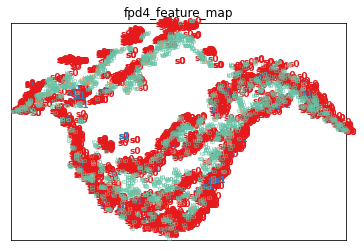

In [22]:
source_x = feature_extractor.predict({name: source_data[name] for name in feature_names})
target_x = feature_extractor.predict({name: set_data[name] for name in feature_names})
a_score = proxy_a_distance(source_x, target_x)
print(set_name, 'a_score', a_score)
fig, ax = plt.subplots()
_ = plot_tsne_source_target(source_x, source_data['fpd4'].values, target_x, set_data['fpd4'].values, ax,
                            name='{}_feature_map'.format('fpd4'))

In [18]:
# the main model part is in sync with domain adaptation
model.trainable_variables

[<tf.Variable 'bottom_shared_dnn/kernel0:0' shape=(31, 96) dtype=float32, numpy=
 array([[-0.18958525, -0.0349797 , -0.04534877, ..., -0.04852929,
         -0.1696269 , -0.13333225],
        [ 0.08653495,  0.08113731, -0.12015709, ...,  0.01368396,
          0.04944049, -0.01023505],
        [ 0.09860473,  0.14765672, -0.1298222 , ...,  0.02662388,
          0.21694162, -0.09619938],
        ...,
        [ 0.1321406 ,  0.0107715 , -0.23330379, ..., -0.04151056,
         -0.09467486, -0.03422162],
        [ 0.03757354,  0.23319261, -0.05097578, ...,  0.01817932,
          0.01144453,  0.02236599],
        [ 0.06138775,  0.06117497,  0.32041788, ..., -0.15239951,
         -0.10344701,  0.16039881]], dtype=float32)>,
 <tf.Variable 'bottom_shared_dnn/kernel1:0' shape=(96, 96) dtype=float32, numpy=
 array([[ 0.11943071,  0.08826531, -0.1501965 , ...,  0.16093773,
         -0.16265713, -0.08662477],
        [-0.05163181, -0.04840375,  0.09323265, ..., -0.06614023,
         -0.21244194, -0.07

In [24]:
# composite optimizer does not support serialization, so in order to save the model we have to recompile the main model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=loss_fns,
              metrics=metrics_logger)

In [25]:
# trainable variables are the same with before
model.trainable_variables

[<tf.Variable 'bottom_shared_dnn/kernel0:0' shape=(31, 96) dtype=float32, numpy=
 array([[-0.1814503 , -0.04445853,  0.25365916, ..., -0.02884322,
         -0.25889248, -0.18337736],
        [ 0.0743752 ,  0.09893888,  0.00728303, ...,  0.0661046 ,
          0.05716342,  0.01268009],
        [ 0.05268449,  0.04142283,  0.2429642 , ...,  0.1202907 ,
          0.13199885, -0.14314456],
        ...,
        [ 0.13008086,  0.04329101, -0.15244249, ...,  0.00994699,
         -0.08330194, -0.00720736],
        [ 0.05360007,  0.09049317,  0.00536939, ...,  0.06231819,
         -0.00595377,  0.01389045],
        [ 0.08926344, -0.01714184,  0.19133638, ..., -0.2381346 ,
         -0.17206934,  0.06979264]], dtype=float32)>,
 <tf.Variable 'bottom_shared_dnn/kernel1:0' shape=(96, 96) dtype=float32, numpy=
 array([[ 0.12544346,  0.09584421, -0.12886213, ...,  0.11336764,
         -0.16067424, -0.06457647],
        [-0.04647758, -0.09674615,  0.03705568, ..., -0.00633299,
         -0.20457436, -0.04

In [20]:
# the predictions are the same with before
predictions = model.predict({name: set_data[name] for name in feature_names})
pred = predictions['fpd4'][:, 0]
auc_score = roc_auc_score(set_data['fpd4'].values, pred,
                          sample_weight=set_data['fpd4_mask'].values)
fpr, tpr, _ = roc_curve(set_data['fpd4'].values, pred,
                        sample_weight=set_data['fpd4_mask'].values)
ks = np.max(np.abs(tpr - fpr))
print('auc {}, ks {}'.format(auc_score, ks))

auc 0.7087798458356834, ks 0.35717758717933756


In [26]:
# which means we can deploy the model online now!
save_model(model, 'online.h5')

